# CompSem material
Notebook to keep at hand all CompSem related functions that we might need for our final project.
To try this functions we have to use the Uni's JupyterHub server, so they won't work here. This is just a reference place to keep all useful code, preferably with the example outputs taken from executing it in the server. 

Proposed workflow:
* Make sure that you are using the latest version of this file
* Upload this file to the server
* Edit, add and run whatever new material you found
* Download the file and save it here, deleting the previous version. In case maaany changes were done then leave the previous version but add the current date to its name, to know that it's a deprecated version of the file

## Setup

In [1]:
# imports
from __future__ import division
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import codecs
import json
from itertools import chain, permutations, combinations
from collections import Counter, defaultdict
import configparser
import os
import random
from textwrap import fill
import scipy
import sys
from copy import deepcopy
#import spacy
from annoy import AnnoyIndex
from nltk.parse import CoreNLPParser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

from IPython.display import Latex, display

pd.set_option('max_colwidth', 250)

[nltk_data] Downloading package punkt to /home/lopez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/lopez/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Load up config file (needs path; adapt env var if necessary); local imports

# load config file, set up paths, make project-specific imports
config_path = os.environ.get('VISCONF')
if not config_path:
    # try default location, if not in environment
    default_path_to_config = '../../clp-vision/Config/default.cfg'
    if os.path.isfile(default_path_to_config):
        config_path = default_path_to_config

assert config_path is not None, 'You need to specify the path to the config file via environment variable VISCONF.'        

config = configparser.ConfigParser()
with codecs.open(config_path, 'r', encoding='utf-8') as f:
    config.read_file(f)

corpora_base = config.get('DEFAULT', 'corpora_base')
preproc_path = config.get('DSGV-PATHS', 'preproc_path')
dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')


sys.path.append(dsgv_home + '/Utils')
from utils import icorpus_code, plot_labelled_bb, get_image_filename, query_by_id
from utils import plot_img_cropped, plot_img_ax, invert_dict, get_a_by_b
sys.path.append(dsgv_home + '/WACs/WAC_Utils')
from wac_utils import create_word2den, is_relational
sys.path.append(dsgv_home + '/Preproc')
from sim_preproc import load_imsim, n_most_sim

sys.path.append('../Common')
from data_utils import load_dfs, plot_rel_by_relid, get_obj_bb, compute_distance_objs
from data_utils import get_obj_key, compute_relpos_relargs_row, get_all_predicate
from data_utils import compute_distance_relargs_row, get_rel_type, get_rel_instances
from data_utils import compute_obj_sizes_row

### Selecting which DataFrames to use

In [3]:
# Load up preprocessed DataFrames. Slow!
# These DataFrames are the result of pre-processing the original corpus data,
# as per dsg-vision/Preprocessing/preproc.py

df_names = [
#             'saiapr_bbdf',
            'mscoco_bbdf',
            'mscoco_catsdf',
            'cococapdf',
             'vgregdf',
             'vgimgdf',
             'vgreldf',
             'vgobjdf',
             'vgpardf' 
#             'flickr_bbdf',
#             'flickr_capdf',
#             'flickr_objdf',
#             'ade_imgdf',
#             'ade_objdf',
#             'cub_bbdf',
#             'cub_attrdf',
#             'cub_partdf',
#             'cub_capdf'
           ]
df = load_dfs(preproc_path, df_names)

# a derived DF, containing only those region descriptions which I was able to resolve
# df['vgpregdf'] = df['vgregdf'][df['vgregdf']['pphrase'].notnull() & 
#                                (df['vgregdf']['pphrase'] != '')]

# Corpus analysis
Getting an idea of NL/V characteristics of the corpus. Sizes, distributions, general statistics, etc

In [7]:
current_df = df['vgpardf']

### Description

In [8]:
current_df.head()

,image_id,paragraph,i_corpus
0,2356347,A large building with bars on the windows in front of it. There is people walking in front of the building. There is a street in front of the building with many cars on it.,5
1,2317429,"A white round plate is on a table with a plastic tablecloth on it. Two foil covered food halves are on the white plate along with a serving of golden yellow french fries. Next to the white plate in a short, topless, plastic container is a whit...",5
2,2414610,A woman in a blue tennis outfit stands on a green tennis court. She is swinging a blue tennis racket. There is a green tennis ball above her head.,5
3,2365091,A large red and white train is traveling on tracks in a what looks to be a rural area. There are trees and hills in the background and the ground looks dry. The train has many large windows for the passengers to look out of. The train is mostly w...,5
4,2383120,A very clean and tidy a bathroom. Everything is a neat porcelain white. This bathroom is both retro and modern.,5


In [9]:
current_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19561 entries, 0 to 19560
Data columns (total 3 columns):
image_id     19561 non-null int64
paragraph    19561 non-null object
i_corpus     19561 non-null int64
dtypes: int64(2), object(1)
memory usage: 611.3+ KB


### Language Corpus

In [11]:
full_sentences = np.asarray(current_df.paragraph)
print(len(full_sentences))

19561


In [30]:
#tokenizing our sentences
tokenized_sentences = [nltk.tokenize.word_tokenize(sen.lower()) for sen in full_sentences]

['a',
 'very',
 'clean',
 'and',
 'tidy',
 'a',
 'bathroom',
 '.',
 'everything',
 'is',
 'a',
 'neat',
 'porcelain',
 'white',
 '.',
 'this',
 'bathroom',
 'is',
 'both',
 'retro',
 'and',
 'modern',
 '.']

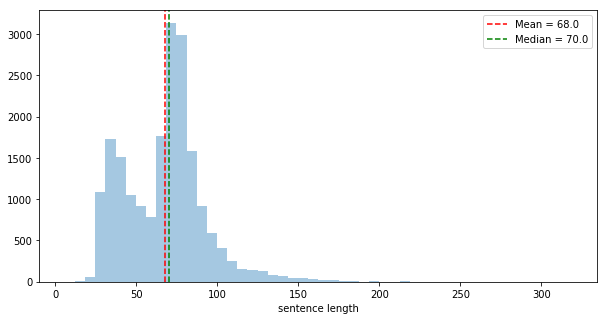

In [17]:
#Avg sentence length
sent_lens = [len(sentence) for sentence in tokenized_sentences]
mean = np.mean(sent_lens)
median = np.median(sent_lens)

fig = plt.figure(figsize=(10,5))
ax = sns.distplot(sent_lens, norm_hist=False, kde=False)
ax.set(xlabel='sentence length', ylabel='')

plt.axvline(mean,color='r', linestyle='--')
plt.axvline(median,color='g', linestyle='--')

plt.legend({f'Mean = {mean.round()}':mean,f'Median = {median.round()}':median})


plt.show()

In [18]:
#Word and POS tag freq analysis
words = list(chain.from_iterable(tokenized_sentences))
fdist = nltk.FreqDist(words)

In [19]:
#Hapaxes
hapaxes = fdist.hapaxes()
len(hapaxes)

5928

In [20]:
pd.DataFrame([random.sample(hapaxes, 10), random.sample(hapaxes, 10), random.sample(hapaxes, 10), random.sample(hapaxes, 10)])

,0,1,2,3,4,5,6,7,8,9
0,locking,overgrowing,chatting,billows,hugo,labeling,weston,joey,45379,waves.there
1,scenario,gore,walkingon,artichokes,bruck,potpourri,sharpened,undecipherable,keystone,ringleader
2,umpires,socks.his,changed,butting,ticked,gam,expected,riden,deleted*,53x
3,regal,meaning,hella,glistens,measurement,catfish,bench.the,signas,nickel,aged-looking


In [21]:
#getting POS tags
pos_sents = [nltk.pos_tag(i) for i in tokenized_sentences]
pos_sents = [item for sublist in pos_sents for item in sublist]

In [22]:
nouns = [word[0] for word in pos_sents if word[1][0] == 'N']
adjectives = [word[0] for word in pos_sents if word[1][0] == 'J']
verbs = [word[0] for word in pos_sents if word[1][0] == 'V']

nouns_mc = nltk.FreqDist(nouns).most_common(15)
verbs_mc = nltk.FreqDist(verbs).most_common(15)
adjectives_mc = nltk.FreqDist(adjectives).most_common(15)

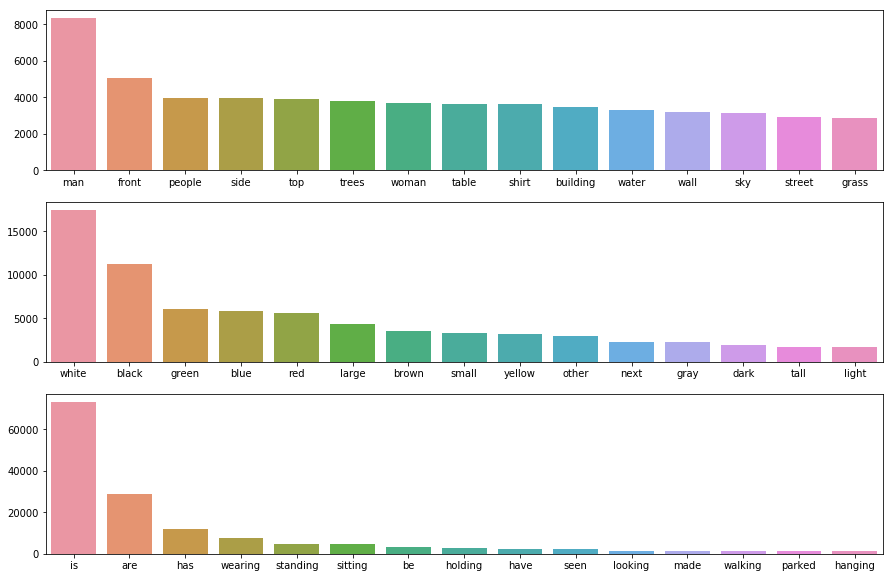

In [23]:
#pretty plots

fig, axes = plt.subplots(3)

fig.set_size_inches(15, 10)

sns.barplot(x=[i[0] for i in nouns_mc], y=[i[1] for i in nouns_mc], 
            ax=axes[0])


sns.barplot(x=[i[0] for i in adjectives_mc], y=[i[1] for i in adjectives_mc], 
            ax=axes[1])


sns.barplot(x=[i[0] for i in verbs_mc], y=[i[1] for i in verbs_mc], 
            ax=axes[2], label='oksffas')



plt.show()

### Relations between the different dfs belonging to Visual Genome project
First let's get an idea of how vg is divided by retrieving the relevant info for only one image, id = 1

In [4]:
df['vgregdf'].head()

,i_corpus,image_id,coco_id,flickr_id,region_id,phrase,bb,rel_ids,rels,pphrase
0,5,1,NaN,NaN,1382,the clock is green in colour,"[421, 57, 82, 139]",None,None,None
1,5,1,NaN,NaN,1383,shade is along the street,"[194, 372, 182, 109]",[15927],"[[5045, ON, along.r.01, 5046]]",shade|5045|shade.n.01 is along the street|5046|street.n.01
2,5,1,NaN,NaN,1384,man is wearing sneakers,"[241, 491, 61, 30]",[15928],"[[1058529, wears, wear.v.01, 5048]]",man|1058529|man.n.01 is wearing sneakers|5048|gym_shoe.n.01
3,5,1,NaN,NaN,1385,cars headlights are off,"[617, 377, 36, 36]",[15929],"[[5049, has, have.v.01, 5050]]",
4,5,1,NaN,NaN,1386,bikes are parked at the far edge,"[322, 298, 41, 49]",None,None,None


In [5]:
# we can see that for this one image we have ~260 relations 
df['vgregdf'][df['vgregdf']['image_id']==1]

,i_corpus,image_id,coco_id,flickr_id,region_id,phrase,bb,rel_ids,rels,pphrase
0,5,1,NaN,NaN,1382,the clock is green in colour,"[421, 57, 82, 139]",None,None,None
1,5,1,NaN,NaN,1383,shade is along the street,"[194, 372, 182, 109]",[15927],"[[5045, ON, along.r.01, 5046]]",shade|5045|shade.n.01 is along the street|5046|street.n.01
2,5,1,NaN,NaN,1384,man is wearing sneakers,"[241, 491, 61, 30]",[15928],"[[1058529, wears, wear.v.01, 5048]]",man|1058529|man.n.01 is wearing sneakers|5048|gym_shoe.n.01
3,5,1,NaN,NaN,1385,cars headlights are off,"[617, 377, 36, 36]",[15929],"[[5049, has, have.v.01, 5050]]",
4,5,1,NaN,NaN,1386,bikes are parked at the far edge,"[322, 298, 41, 49]",None,None,None
5,5,1,NaN,NaN,1432,A sign on the facade of the building,"[122, 14, 84, 178]",[15930],"[[1058507, ON, along.r.01, 1058508]]",A sign|1058507|sign.n.02 on the facade of the building|1058508|building.n.01
6,5,1,NaN,NaN,1433,A tree trunk on the sidewalk,"[624, 236, 96, 332]",[15931],"[[5055, ON, along.r.01, 1058534]]",A tree trunk|5055|trunk.n.01 on the sidewalk|1058534|sidewalk.n.01
7,5,1,NaN,NaN,1434,A man in a red shirt,"[238, 247, 69, 270]",[15932],"[[1058529, has, have.v.01, 1058511]]",A man|1058529|man.n.01 in a red shirt|1058511|shirt.n.01
8,5,1,NaN,NaN,1435,A brick sidewalk beside the street,"[150, 495, 451, 100]",[15933],"[[1058534, next to, next.r.01, 1058539]]",
9,5,1,NaN,NaN,1436,The back of a white car,"[711, 345, 82, 179]",[15934],"[[1058515, has, have.v.01, 5060]]",The back|5060|back.n.01 of a white car|1058515|car.n.01


In [6]:
df['vgimgdf'].head()

,i_corpus,image_id,coco_id,flickr_id,width,height
0,5,1,NaN,NaN,800,600
1,5,2,NaN,NaN,800,600
2,5,3,NaN,NaN,640,480
3,5,4,NaN,NaN,640,480
4,5,5,NaN,NaN,800,600


In [7]:
df['vgimgdf'][df['vgimgdf']['image_id']==1]

,i_corpus,image_id,coco_id,flickr_id,width,height
0,5,1,NaN,NaN,800,600


In [8]:
df['vgreldf'].head()

,i_corpus,image_id,rel_syn,predicate,rel_id,sub_syn,sub_id,obj_syn,obj_id
0,5,1,along.r.01,ON,15927,shade.n.01,5045,street.n.01,5046
1,5,1,wear.v.01,wears,15928,man.n.01,1058529,gym_shoe.n.01,5048
2,5,1,have.v.01,has,15929,car.n.01,5049,headlight.n.01,5050
3,5,1,along.r.01,ON,15930,sign.n.02,1058507,building.n.01,1058508
4,5,1,along.r.01,ON,15931,trunk.n.01,5055,sidewalk.n.01,1058534


In [9]:
df['vgreldf'][df['vgreldf']['image_id']==1]

,i_corpus,image_id,rel_syn,predicate,rel_id,sub_syn,sub_id,obj_syn,obj_id
0,5,1,along.r.01,ON,15927,shade.n.01,5045,street.n.01,5046
1,5,1,wear.v.01,wears,15928,man.n.01,1058529,gym_shoe.n.01,5048
2,5,1,have.v.01,has,15929,car.n.01,5049,headlight.n.01,5050
3,5,1,along.r.01,ON,15930,sign.n.02,1058507,building.n.01,1058508
4,5,1,along.r.01,ON,15931,trunk.n.01,5055,sidewalk.n.01,1058534
5,5,1,have.v.01,has,15932,man.n.01,1058529,shirt.n.01,1058511
6,5,1,next.r.01,next to,15933,sidewalk.n.01,1058534,street.n.01,1058539
7,5,1,have.v.01,has,15934,car.n.01,1058515,back.n.01,5060
8,5,1,have.v.01,has,15935,man.n.01,1058529,spectacles.n.01,1058518
9,5,1,along.r.01,ON,15936,parking_meter.n.01,1058519,sidewalk.n.01,1058534


In [10]:
df['vgobjdf'].head()

,i_corpus,image_id,obj_id,syn,name,bb
0,5,1,1058498,clock.n.01,clock,"[421, 91, 79, 339]"
1,5,1,5046,street.n.01,street,"[77, 328, 714, 262]"
2,5,1,5045,shade.n.01,shade,"[119, 338, 274, 192]"
3,5,1,1058529,man.n.01,man,"[238, 249, 60, 262]"
4,5,1,5048,gym_shoe.n.01,sneakers,"[243, 489, 52, 26]"


In [11]:
# 39 objects in this image
df['vgobjdf'][df['vgobjdf']['image_id']==1]

,i_corpus,image_id,obj_id,syn,name,bb
0,5,1,1058498,clock.n.01,clock,"[421, 91, 79, 339]"
1,5,1,5046,street.n.01,street,"[77, 328, 714, 262]"
2,5,1,5045,shade.n.01,shade,"[119, 338, 274, 192]"
3,5,1,1058529,man.n.01,man,"[238, 249, 60, 262]"
4,5,1,5048,gym_shoe.n.01,sneakers,"[243, 489, 52, 26]"
5,5,1,5050,headlight.n.01,headlight,"[514, 366, 23, 15]"
6,5,1,5049,car.n.01,car,"[479, 315, 74, 98]"
7,5,1,5051,bicycle.n.01,bike,"[318, 319, 28, 34]"
8,5,1,1058535,bicycle.n.01,bike,"[334, 319, 29, 35]"
9,5,1,1058507,sign.n.02,sign,"[118, 13, 88, 182]"


In [12]:
df['vgpardf'].head()

,image_id,paragraph,i_corpus
0,2356347,A large building with bars on the windows in front of it. There is people walking in front of the building. There is a street in front of the building with many cars on it.,5
1,2317429,"A white round plate is on a table with a plastic tablecloth on it. Two foil covered food halves are on the white plate along with a serving of golden yellow french fries. Next to the white plate in a short, topless, plastic container is a whit...",5
2,2414610,A woman in a blue tennis outfit stands on a green tennis court. She is swinging a blue tennis racket. There is a green tennis ball above her head.,5
3,2365091,A large red and white train is traveling on tracks in a what looks to be a rural area. There are trees and hills in the background and the ground looks dry. The train has many large windows for the passengers to look out of. The train is mostly w...,5
4,2383120,A very clean and tidy a bathroom. Everything is a neat porcelain white. This bathroom is both retro and modern.,5


In [13]:
df['vgpardf'][df['vgpardf']['image_id']==1]

,image_id,paragraph,i_corpus


### Working with Vision Corpus

In [4]:
#plotting one image + bb
pick_row = 2
this_row = df['vgregdf'].iloc[pick_row]
this_row

i_corpus                                                               5
image_id                                                               1
coco_id                                                              NaN
flickr_id                                                            NaN
region_id                                                           1384
phrase                                           man is wearing sneakers
bb                                                    [241, 491, 61, 30]
rel_ids                                                          [15928]
rels                                 [[1058529, wears, wear.v.01, 5048]]
pphrase      man|1058529|man.n.01 is wearing sneakers|5048|gym_shoe.n.01
Name: 2, dtype: object

In [5]:
ic, ii, ri, rbb = this_row['i_corpus image_id region_id bb'.split()].values
rel_id = this_row['rel_ids'][0]
print('The original phrase:\n  ', this_row['phrase'])

The original phrase:
   man is wearing sneakers


In [6]:
#this line is retrieving the relevant bbs for that relation
_, bbs = plot_rel_by_relid(df['vgreldf'], df['vgobjdf'], rel_id)
bbs

[([238, 249, 60, 262], ('1058529', 'b')), ([243, 489, 52, 26], ('5048', 'g'))]

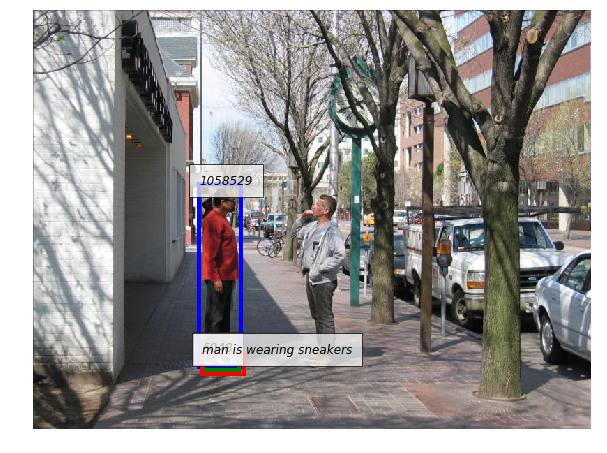

In [7]:
plot_labelled_bb(get_image_filename(config, ic, ii), bbs + [(rbb, this_row['phrase'])])

In [8]:
#retrieving all labeled bbs for all relations of image w/ id=1
all_rel_ids = df['vgreldf'][df['vgreldf']['image_id']==1]['rel_id']
bbs = []
for rel in all_rel_ids:
    current_rel_bbs = plot_rel_by_relid(df['vgreldf'], df['vgobjdf'], rel)[1]
    for i in range(len(current_rel_bbs)):
        bbs.append(current_rel_bbs[i])

In [9]:
# getting list of bbs only, not label or colour
only_bbs = [bb[0] for bb in bbs]

#original format [x_top_left_corner, y_top_left_corner, width, height]
#note that height goes from top to bottom of the image following the normal coord system of images
#converting them to this format: [x_top_left_corner, y_top_left_corner, x_bottom_right, y_bottom_right ]
def bb_convert(bb):
    return [bb[0], bb[1], bb[0]+bb[2] ,bb[1]+bb[3]]

only_bbs = [bb_convert(bb) for bb in only_bbs]

In [10]:
#number of rels in the image
len(all_rel_ids)

41

In [11]:
#retrieve size/area of bb
#note about bb values: In images x goes from left to right, y goes from top to bottom, the origin is upper left corner
# the 4 values in our bb are [x_top_left_corner, y_top_left_corner, x_bottom_right, y_bottom_right ]
def bb_size(bb):
    return np.abs((bb[2]-bb[0])*(bb[3]-bb[1]))

In [12]:
#getting avg area of rel bb
rel_areas = np.array([bb_size(bb) for bb in only_bbs])
avg_rel_area = rel_areas.mean()

In [13]:
#getting area of intersection between two overlapping rectangles
def inter_rectangles(bb1, bb2):
    dx = min(bb1[2], bb2[2]) - max(bb1[0], bb2[0])
    dy = min(bb1[3], bb2[3]) - max(bb1[1], bb2[1])
    if (dx>=0) and (dy>=0):
        return dx*dy
    else:
        return 0

In [14]:
#getting intersection area divided by union area
def inter_over_union(bb1, bb2):
    area1 = bb_size(bb1)
    area2 = bb_size(bb2)
    inter = inter_rectangles(bb1, bb2)
    return (inter)/(area1+area2-inter)

In [15]:
#generating all pair combination (not caring about order) of bbs
pairs = list(combinations(only_bbs, 2))
#making sure that didn t explote in number
print(len(pairs))

3321


In [16]:
#getting average intersection over union
avg_inter_over_union = np.mean([inter_over_union(pair[0], pair[1]) for pair in pairs])

In [17]:
#check which values exist
#np.unique([inter_over_union(pair[0], pair[1]) for pair in pairs], return_counts=True)

In [18]:
#very small because most pairs dont intersect
avg_inter_over_union

0.09154632350543696

In [19]:
#Let's only take into account the ones that do
intersecting_pairs = [pair for pair in pairs if inter_over_union(pair[0], pair[1]) > 0]
print(len(intersecting_pairs))
avg_inter_over_union2 = np.mean([inter_over_union(pair[0], pair[1]) for pair in intersecting_pairs])
print(avg_inter_over_union2)

1430
0.2126051331199693


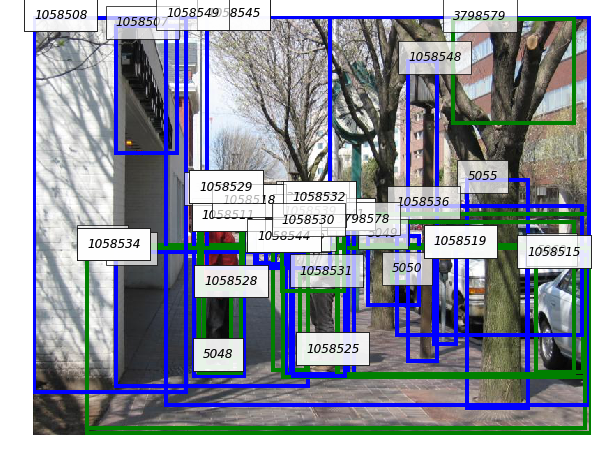

In [20]:
#plotting picture and all bbs from relations
#not very useful but now we know how to do it. 
plot_labelled_bb(get_image_filename(config, ic, ii), bbs)

### Exploring MSCOCO

In [21]:
df['mscoco_bbdf'].head()

,i_corpus,image_id,region_id,bb,cat
0,1,480023,86,"[116.95, 305.86, 285.3, 266.03]",58
1,1,50518,89,"[245.54, 208.17, 40.14, 19.1]",58
2,1,142589,93,"[288.4, 18.07, 211.6, 331.33]",58
3,1,209263,113,"[126.5, 475.24, 77.68, 76.73]",58
4,1,15307,116,"[185.57, 93.4, 219.97, 420.29]",58


In [22]:
#getting the avg number of regions per image
#7.37
ids = np.unique(df['mscoco_bbdf']['image_id'])
totals = [len(df['mscoco_bbdf'][df['mscoco_bbdf']['image_id'] == im_id]['region_id']) for im_id in ids]
print(np.mean(totals))

7.369634872869483


In [23]:
#getting the number of images per category
cats = np.unique(df['mscoco_bbdf']['cat'])
totals = [len(df['mscoco_bbdf'][df['mscoco_bbdf']['cat'] == cat]) for cat in cats]
#avg number of images per cat
#https://gist.github.com/AruniRC/7b3dadd004da04c80198557db5da4bda
print(np.mean(totals))

7561.3375


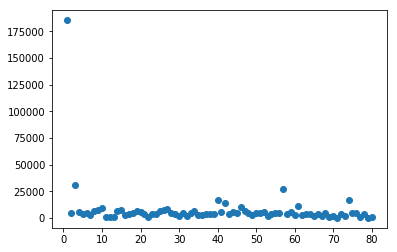

In [24]:
plt.scatter(range(1, len(totals)+1), totals)

In [25]:
#finding that outlier
#corresponding to the cat "background"
np.argmax(totals)

0

In [26]:
#avg size of objects
#len(all_bbs) = 604907
all_bbs = [bb_convert(df['mscoco_bbdf']['bb'][i]) for i in range(len(df['mscoco_bbdf']['bb']))]

In [27]:
coco_areas = [bb_size(bb) for bb in all_bbs]
print(np.mean(coco_areas)) #in pixels, still need to compare this to VG result

21302.1547852822


In [28]:
#same analysis per category
bbs_per_cat = []
for cat in cats: # cats = np.unique(df['mscoco_bbdf']['cat'])
    current_bbs = np.asarray(df['mscoco_bbdf'][df['mscoco_bbdf']['cat']== cat]['bb'])
    bbs_per_cat.append([bb_convert(current_bbs[i]) for i in range(len(current_bbs))])

In [29]:
coco_areas_per_cat = []
for i in range(len(bbs_per_cat)):
    current_areas = [bb_size(bb_convert(bb)) for bb in bbs_per_cat[i]]
    coco_areas_per_cat.append(current_areas)
avg_area_per_cat = [np.mean(lista) for lista in coco_areas_per_cat]

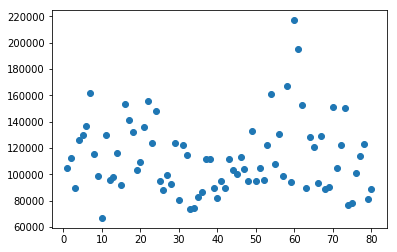

In [30]:
plt.scatter(range(1, len(avg_area_per_cat)+1), avg_area_per_cat)

In [36]:
# getting the two categories with largest avg on image size
#still have to check this, it doesn t look like the graph
sorted_args = np.argsort(avg_area_per_cat)+1
sorted_args
#corresponding to sports ball and traffic light, respectively

array([10, 33, 34, 74, 75, 30, 79, 40, 35, 36, 26, 68, 80,  3, 63, 39, 42,
       69, 15, 28, 66, 59, 48, 50, 41, 25, 12, 52, 13, 57,  9, 27, 45, 76,
       44, 19, 47, 51,  1, 71, 55, 20, 38, 43, 37,  2, 46, 77, 32,  8, 14,
       65, 53, 31, 72, 78, 29, 23,  4, 64, 67,  5, 11, 56, 18, 49, 21,  6,
       17, 24, 73, 70, 62, 16, 22, 54,  7, 58, 61, 60])

In [37]:
#getting the intersection over union per category
avg_inter_over_union_per_image = []
for im_id in ids: #ids = np.unique(df['mscoco_bbdf']['image_id'])
    current_bbs = np.asarray(df['mscoco_bbdf'][df['mscoco_bbdf']['image_id']== im_id]['bb'])
    #generating all pair combination (not caring about order) of bbs
    pairs = list(combinations(current_bbs, 2))
    avg_inter_over_union_per_image.append(np.mean([inter_over_union(pair[0], pair[1]) for pair in pairs]))

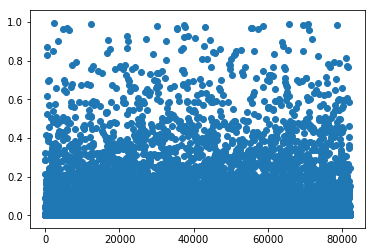

In [38]:
plt.scatter(range(len(ids)), avg_inter_over_union_per_image)

(array([6.9814e+04, 1.2210e+03, 5.5900e+02, 3.2700e+02, 2.1300e+02,
        1.1700e+02, 8.0000e+01, 6.0000e+01, 2.8000e+01, 3.3000e+01]),
 array([0.        , 0.09952316, 0.19904632, 0.29856948, 0.39809264,
        0.4976158 , 0.59713896, 0.69666212, 0.79618527, 0.89570843,
        0.99523159]),
 <a list of 10 Patch objects>)

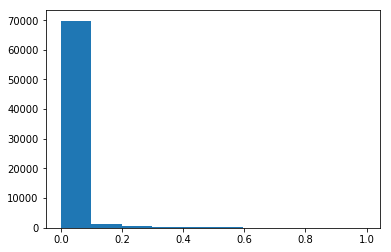

In [39]:
plt.hist(avg_inter_over_union_per_image)

### Visualizing the images

In [49]:
#testing with image with image_id = 50518
ic, ii = df['mscoco_bbdf'].iloc[1]['i_corpus image_id'.split()]
get_image_filename(config, ic, ii)

'/ImageCorpora/MSCOCO/train2014/COCO_train2014_000000050518.jpg'

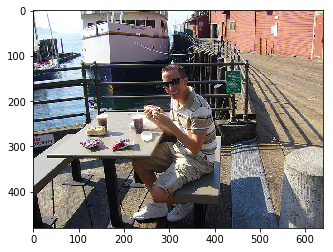

In [50]:
plt.imshow(plt.imread(get_image_filename(config, ic, ii)))

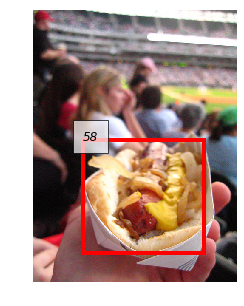

In [51]:
#plotting with labels
ic, ii, bb, cat = df['mscoco_bbdf'].iloc[0]['i_corpus image_id bb cat'.split()]
plot_labelled_bb(get_image_filename(config, ic, ii), [(bb, cat)], figsize=(5,5))

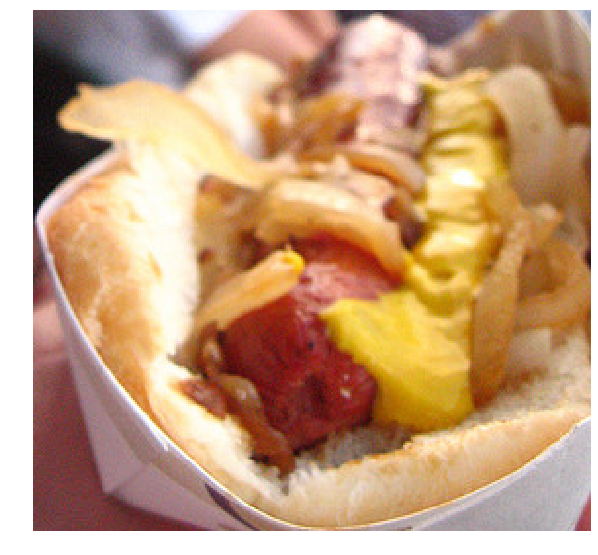

In [74]:
plot_img_cropped(get_image_filename(config, ic, ii), [int(e) for e in bb]);